In [1]:
import os
import re
import random
import pickle
import itertools
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [2]:
#############
# Utils
#############
def calc_inter_sim_mean_std(embs):
    sim = embs @ embs.T
    upper_triangle_indices = np.triu_indices(sim.shape[0], k=1)
    upper_triangle_values = sim[upper_triangle_indices]
    return np.mean(upper_triangle_values), np.std(upper_triangle_values)

def calc_inter_sim_z_score(embs, mean, std):
    sim = embs @ embs.T
    upper_triangle_indices = np.triu_indices(sim.shape[0], k=1)
    upper_triangle_values = sim[upper_triangle_indices]
    z_score = (upper_triangle_values - mean) / std
    return np.mean(z_score)

In [3]:
################
# Load DEG list
################
# 1. DEG
degs_data = []
with open("../data/fig4/Disease_information_DEGs.gmt", "r") as f:
    for line in f:
        line = line.strip().split("\t")
        degs_data.append([line[0], line[1], ",".join(line[2:])])
degs_data = pd.DataFrame(degs_data, columns=["DatasetID", "dataset", "genes"])
degs_data["species"] = degs_data["dataset"].apply(lambda x: x.split("|")[-1])

# 2. Use only DEGs of human
degs_data = degs_data[degs_data["species"] == "Homo sapiens"].reset_index(drop=True)
display(degs_data.head())
display(degs_data.shape)

# 2. Disese-datasetID
DatasetID_disease = pd.read_csv("../data/fig4/Disease_information_Datasets.csv", encoding="ISO-8859-1")
display(DatasetID_disease.head())
display(DatasetID_disease.shape)

# 3. Load Disease to be used
disease2use = pd.read_csv("../data/fig4/DiSignAtlas_human_diseases_more_than_10_reports.csv")
display(disease2use.head())
display(disease2use.shape)

,DatasetID,dataset,genes,species
0,DSA00004,GSE224022|GSM7009973;GSM7009974;GSM7009976;GSM...,"5307,109729169,10642,7083,4009,9787,55301,7031...",Homo sapiens
1,DSA00005,GSE126342|GSM3596881;GSM3596882;GSM3596883;GSM...,"107985362,101927007,107986623,810,1755,4058,14...",Homo sapiens
2,DSA00006,GSE126342|GSM3596906;GSM3596907;GSM3596908;GSM...,"101927007,3736,4045,114,646643,100506869,11293...",Homo sapiens
3,DSA00008,GSE224253|GSM7018324;GSM7018325;GSM7018326;GSM...,"100616354,100616227,100616131,100616344,767568...",Homo sapiens
4,DSA00011,GSE223245|GSM6943825;GSM6943826;GSM6943827;GSM...,"55301,57126,3250,3240,10079,199675,1910,54757,...",Homo sapiens


(5773, 4)

,dsaid,accession,platform,deg_count,disease,diseaseid,tissue,data_source,library_strategy,organism,control_case_sample_count,definition
0,DSA00001,GSE224398,GPL21103,1000,Alzheimer's Disease,C0002395,Hippocampus,GEO,scRNA-Seq,Mus musculus,1|1,DO:An Alzheimer's disease that has_material_ba...
1,DSA00002,GSE224398,GPL21103,1000,Alzheimer's Disease,C0002395,Hippocampus,GEO,scRNA-Seq,Mus musculus,1|1,DO:An Alzheimer's disease that has_material_ba...
2,DSA00003,GSE224398,GPL21103,1000,Alzheimer's Disease,C0002395,Hippocampus,GEO,scRNA-Seq,Mus musculus,1|1,DO:An Alzheimer's disease that has_material_ba...
3,DSA00004,GSE224022,GPL16791,1000,Retinoblastoma,C0035335,Retina,GEO,RNA-Seq,Homo sapiens,4|5,DO:A retinal cell cancer and malignant neoplas...
4,DSA00005,GSE126342,GPL11154,1000,Congenital Myotonic Dystrophy,C0410226,Skeletal muscle,GEO,RNA-Seq,Homo sapiens,9|11,MONDO:An inherited progressive disorder affect...


(10306, 12)

,disease,count,mesh_id,top1_disease,top2_disease,top3_disease,top4_disease,top5_disease,top1_mesh,top2_mesh,top3_mesh,top4_mesh,top5_mesh
0,Influenza,102,D007251,"Influenza, Human",Influenza in Birds,Vaccinia,Infectious Mononucleosis,Respiratory Syncytial Virus Infections,D007251,D005585,D014615,D007244,D018357
1,COVID-19,99,D000094024,Post-Acute COVID-19 Syndrome,Trisomy 18 Syndrome,"Conjunctivitis, Inclusion",Rabies,Vaccinia,D000094024,D000073842,D003235,D011818,D014615
2,Systemic Lupus Erythematosus,86,D008181,"Panniculitis, Lupus Erythematosus",Sclerosis,Lupus Nephritis,Lupus Vulgaris,"Scleroderma, Diffuse",D015435,D012598,D008181,D008177,D045743
3,Crohn's Disease,76,D003424,Crohn Disease,Celiac Disease,"Diverticulitis, Colonic","Colitis, Lymphocytic","Colitis, Collagenous",D003424,D002446,D004239,D046730,D046729
4,Asthma,72,D059366,"Asthma, Occupational","Asthma, Exercise-Induced","Asthma, Aspirin-Induced",Status Asthmaticus,Anaphylaxis,D059366,D001250,D055963,D013224,D000707


(68, 13)

In [4]:
# 4. DatasetID to be used
def sanitize_directory_name(name):
        forbidden_chars = r'[\\/:*?"<>|\s\']'
        sanitized_name = re.sub(forbidden_chars, '_', name)
        return sanitized_name.strip('_')

datasets2use = []
dataset2disease = {}
dirnames = []
for disease in disease2use["disease"]:
    if disease == "Clear Cell Renal Cell Carcinoma":
          continue
    dirnames.append(sanitize_directory_name(disease))
    datasets = DatasetID_disease[DatasetID_disease["disease"] == disease]["dsaid"].values.tolist()
    # Only use human datasets
    datasets = sorted(list(set(datasets) & set(degs_data["DatasetID"])))
    datasets2use.append(datasets)

    for dataset in datasets:
        dataset2disease[dataset] = sanitize_directory_name(disease)

degs_data2use = degs_data[degs_data["DatasetID"].isin(list(itertools.chain.from_iterable(datasets2use)))].reset_index(drop=True)
degs_data2use["disease"] = degs_data2use["DatasetID"].map(dataset2disease)
display(degs_data2use.head())
display(degs_data2use.shape)

,DatasetID,dataset,genes,species,disease
0,DSA00006,GSE126342|GSM3596906;GSM3596907;GSM3596908;GSM...,"101927007,3736,4045,114,646643,100506869,11293...",Homo sapiens,Myotonic_Dystrophy_Type_1
1,DSA00015,GSE224056|GSM7011081;GSM7011083;GSM7011085;GSM...,"27159,5222,2244,643834,9626,105374547,10798481...",Homo sapiens,Gastric_Cancer
2,DSA00016,GSE224056|GSM7011089;GSM7011091;GSM7011093;GSM...,"5222,643834,8513,495,2694,5225,100126342,40698...",Homo sapiens,Gastric_Cancer
3,DSA00018,GSE223885|GSM6998311;GSM6998312;GSM6998313;GSM...,"249,2215,79937,79908,50486,58160,57126,777,204...",Homo sapiens,COVID-19
4,DSA00030,GSE215424|GSM6634377;GSM6634378;GSM6634379;GSM...,"105373666,101927431,105373665,126638,105375760...",Homo sapiens,Amyotrophic_Lateral_Sclerosis


(2553, 5)

In [ ]:
# (5. Download the statistics results for each dataset)
import requests
from joblib import Parallel, delayed
from tqdm import tqdm
savedir = "../data/fig4/DEG_statistics"
os.makedirs(savedir, exist_ok=True)

def download_gene_analysis_result_DiSignAtlas(datasetID):
    url = f"http://www.inbirg.com/disignatlas/download/diff_results_download/{datasetID}"

    file_name = os.path.join(savedir, datasetID+".tsv")
    try:
        # print("Downloading file...")
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(file_name, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

        # print(f"File downloaded and saved to {file_name}")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
    return None

Parallel(n_jobs=10)(delayed(download_gene_analysis_result_DiSignAtlas)(datasetID) for datasetID in tqdm(degs_data2use["DatasetID"]))

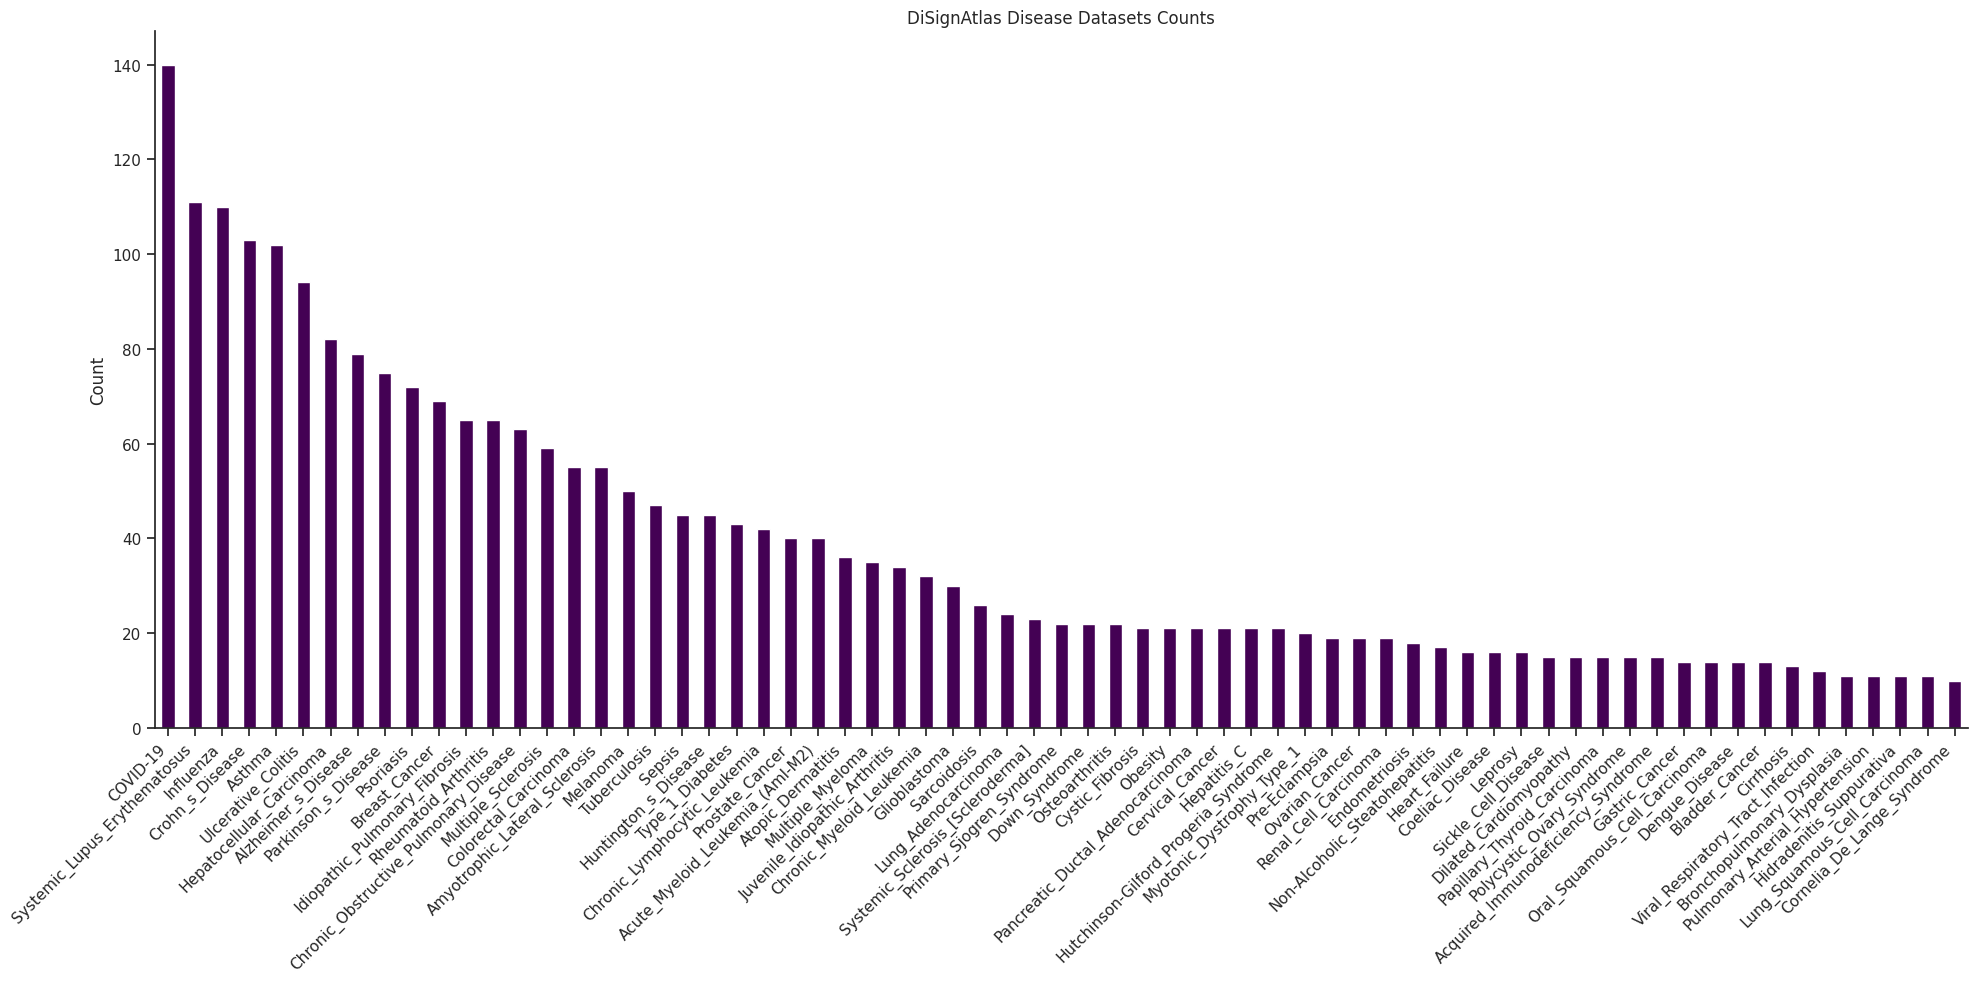

In [5]:
# Visualize the number of datasets per disease
value_counts = degs_data2use["disease"].value_counts()
fig, ax = plt.subplots(figsize=(20, 10))
value_counts.plot(kind='bar', ax=ax, cmap="viridis")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel("")
ax.set_ylabel("Count")
ax.set_title("DiSignAtlas Disease Datasets Counts")
plt.tight_layout()
fig.savefig("../data/fig4/fig4.supple.DiSignAtlas_disease_counts.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

In [6]:
#########################################
# Inter-gene similarity of DEGs using the embeddings of unweighted graph
#########################################
# Prepare the dictionary to convert gene symbols to gene ID
df = pd.read_csv("../data/fig2-3/all_human_gene_interactions_2024-12-18.csv")
symbol2id = {symbol: gene_id for symbol, gene_id in zip(df["from_gene"], df["from_entrez"])}
symbol2id.update({symbol: gene_id for symbol, gene_id in zip(df["to_gene"], df["to_entrez"])})

min_degs = 5
logfc_cutoff = 1.0
pvalue_cutoff = 0.01

def load_dataset(dataset):
    # 0. inspect dataset file
    with open(f"../data/fig4/DEG_statistics/{dataset}.tsv", "r") as f:
        firstline = f.readline()
    if "\t" in firstline:
        delimiter = "\t"
        pvalue_col = "AdjPValue"
        logfc_col = "Log2FC"
    elif "," in firstline:
        delimiter = ","
        pvalue_col = "adjpvalue"
        logfc_col = "log2fc"
    else:
        raise ValueError("Delimiter not found")
    # 1. Load dataset
    gene_analysis_stat = pd.read_table(f"../data/fig4/DEG_statistics/{dataset}.tsv", delimiter=delimiter)
    gene_analysis_stat = gene_analysis_stat.dropna(subset=[pvalue_col])
    gene_analysis_stat = gene_analysis_stat[(gene_analysis_stat[pvalue_col] < pvalue_cutoff) & (np.abs(gene_analysis_stat[logfc_col]) > logfc_cutoff)]
    if len(gene_analysis_stat) < min_degs:
        return None
    gene_analysis_stat["pvalue_rank"] = gene_analysis_stat[pvalue_col].rank()
    gene_analysis_stat["logfc_rank"] = gene_analysis_stat[logfc_col].abs().rank(ascending=False)
    gene_analysis_stat["average_rank"] = (gene_analysis_stat["pvalue_rank"] + gene_analysis_stat["logfc_rank"]) / 2
    return gene_analysis_stat


total_results = []
total_results_unweighted = []
for max_degs in tqdm([10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]):
    inter_sim_z_scores = []
    inter_sim_z_scores_unweighted = []
    for disease, datasets in zip(dirnames, datasets2use):
        # 1. Load embeddings of unweighted graph
        path = f"../data/fig4/GeneRelNet_{disease}_unweighted_graph"
        embs_unweighted = np.load(os.path.join(path, "gene_vec_256.npy"))
        embs_unweighted = normalize(embs_unweighted, axis=1)
        mean_unweighted, std_unweighted = calc_inter_sim_mean_std(embs_unweighted)
        gene_symbols_unweighted = np.load(os.path.join(path, "gene_ids.npy"), allow_pickle=True)
        gene_ids_unweighted = np.array([symbol2id[symbol] for symbol in gene_symbols_unweighted])
        gene_id_to_idx_unweighted = {gene_id: idx for idx, gene_id in enumerate(gene_ids_unweighted)}

        # 2. Load embeddings and gene_ids
        path = f"../data/fig4/GeneRelNet_{disease}"
        embs = np.load(os.path.join(path, "gene_vec_256.npy"))
        embs = normalize(embs, axis=1)
        mean, std = calc_inter_sim_mean_std(embs)
        gene_symbols = np.load(os.path.join(path, "gene_ids.npy"), allow_pickle=True)
        gene_ids = np.array([symbol2id[symbol] for symbol in gene_symbols])
        gene_id_to_idx = {gene_id: idx for idx, gene_id in enumerate(gene_ids)}

        # 3. Calculate z-score of inter-gene similarity of DEGs
        # inter_sim_z_scores = []
        for dataset in datasets:
            # 4. Load gene analysis result and extract DEGs
            gene_analysis_stat = load_dataset(dataset)
            if gene_analysis_stat is None:
                continue
            gene_id_col = "GeneID" if "GeneID" in gene_analysis_stat.columns else "geneid"

            degs = gene_analysis_stat.sort_values("average_rank").iloc[:max_degs][gene_id_col].values
            # 5. filter out DEGs that are not in the embeddings
            degs2use = [int(gene_id) for gene_id in degs if int(gene_id) in gene_id_to_idx]
            if not len(degs2use) >= min_degs:
                continue
            degs_idxes = np.array([gene_id_to_idx[gene_id] for gene_id in degs2use])
            degs_idxes_unweighted = np.array([gene_id_to_idx_unweighted[gene_id] for gene_id in degs2use])

            # 6. Calculate z-score of inter-gene similarity of DEGs
            inter_sim_z_score = calc_inter_sim_z_score(embs[degs_idxes], mean, std)
            inter_sim_z_score_unweighted = calc_inter_sim_z_score(embs_unweighted[degs_idxes_unweighted], mean_unweighted, std_unweighted)
            inter_sim_z_scores.append(inter_sim_z_score)
            inter_sim_z_scores_unweighted.append(inter_sim_z_score_unweighted)
    total_results.append(inter_sim_z_scores)
    total_results_unweighted.append(inter_sim_z_scores_unweighted)

# pickle.dump(total_results, open("../data/fig4/inter_sim_z_scores.pkl", "wb"))
# pickle.dump(total_results_unweighted, open("../data/fig4/inter_sim_z_scores_unweighted.pkl", "wb"))

100%|██████████| 13/13 [54:20<00:00, 250.78s/it]


In [7]:
##############################
# Calculate random expectation
##############################
def load_dataset(dataset):
    # 0. inspect dataset file
    with open(f"../data/fig4/DEG_statistics/{dataset}.tsv", "r") as f:
        firstline = f.readline()
    if "\t" in firstline:
        delimiter = "\t"
        pvalue_col = "AdjPValue"
        logfc_col = "Log2FC"
    elif "," in firstline:
        delimiter = ","
        pvalue_col = "adjpvalue"
        logfc_col = "log2fc"
    else:
        raise ValueError("Delimiter not found")
    # 1. Load dataset
    gene_analysis_stat = pd.read_table(f"../data/fig4/DEG_statistics/{dataset}.tsv", delimiter=delimiter)
    gene_analysis_stat = gene_analysis_stat.dropna(subset=[pvalue_col])
    gene_analysis_stat = gene_analysis_stat[(gene_analysis_stat[pvalue_col] < pvalue_cutoff) & (np.abs(gene_analysis_stat[logfc_col]) > logfc_cutoff)]
    if len(gene_analysis_stat) < min_degs:
        return None
    gene_analysis_stat["pvalue_rank"] = gene_analysis_stat[pvalue_col].rank()
    gene_analysis_stat["logfc_rank"] = gene_analysis_stat[logfc_col].abs().rank(ascending=False)
    gene_analysis_stat["average_rank"] = (gene_analysis_stat["pvalue_rank"] + gene_analysis_stat["logfc_rank"]) / 2
    return gene_analysis_stat


total_results_random = []
np.random.seed(0) # for reproducibility
for max_degs in tqdm([10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]):
    inter_sim_z_scores_random = []
    for disease, datasets in zip(dirnames, datasets2use):
        # 1. Load embeddings and gene_ids
        path = f"../data/fig4/GeneRelNet_{disease}"
        embs = np.load(os.path.join(path, "gene_vec_256.npy"))
        embs = normalize(embs, axis=1)
        mean, std = calc_inter_sim_mean_std(embs)
        gene_symbols = np.load(os.path.join(path, "gene_ids.npy"), allow_pickle=True)
        gene_ids = np.array([symbol2id[symbol] for symbol in gene_symbols])
        gene_id_to_idx = {gene_id: idx for idx, gene_id in enumerate(gene_ids)}

        # 2. Calculate z-score of inter-gene similarity of DEGs
        # inter_sim_z_scores = []
        for dataset in datasets:
            # 3. Load gene analysis result and extract DEGs
            gene_analysis_stat = load_dataset(dataset)
            if gene_analysis_stat is None:
                continue
            gene_id_col = "GeneID" if "GeneID" in gene_analysis_stat.columns else "geneid"

            degs = gene_analysis_stat.sort_values("average_rank").iloc[:max_degs][gene_id_col].values
            # 5. filter out DEGs that are not in the embeddings
            degs2use = [int(gene_id) for gene_id in degs if int(gene_id) in gene_id_to_idx]
            if not len(degs2use) >= min_degs:
                continue
            degs_idxes_random = np.random.choice(np.arange(len(gene_ids)), len(degs2use), replace=False)

            # 6. Calculate z-score of inter-gene similarity of DEGs
            inter_sim_z_score = calc_inter_sim_z_score(embs[degs_idxes_random], mean, std)
            inter_sim_z_scores_random.append(inter_sim_z_score)
    total_results_random.append(inter_sim_z_scores_random)

# pickle.dump(total_results_random, open("../data/fig4/inter_sim_z_scores_random.pkl", "wb"))

100%|██████████| 13/13 [32:11<00:00, 148.56s/it]


In [10]:
##############################
# Calculate similarity of DEGs for context-dependent embeddings
##############################
def load_dataset(dataset):
    # 0. inspect dataset file
    with open(f"../data/fig4/DEG_statistics/{dataset}.tsv", "r") as f:
        firstline = f.readline()
    if "\t" in firstline:
        delimiter = "\t"
        pvalue_col = "AdjPValue"
        logfc_col = "Log2FC"
    elif "," in firstline:
        delimiter = ","
        pvalue_col = "adjpvalue"
        logfc_col = "log2fc"
    else:
        raise ValueError("Delimiter not found")
    # 1. Load dataset
    gene_analysis_stat = pd.read_table(f"../data/fig4/DEG_statistics/{dataset}.tsv", delimiter=delimiter)
    gene_analysis_stat = gene_analysis_stat.dropna(subset=[pvalue_col])
    gene_analysis_stat = gene_analysis_stat[(gene_analysis_stat[pvalue_col] < pvalue_cutoff) & (np.abs(gene_analysis_stat[logfc_col]) > logfc_cutoff)]
    if len(gene_analysis_stat) < min_degs:
        return None
    gene_analysis_stat["pvalue_rank"] = gene_analysis_stat[pvalue_col].rank()
    gene_analysis_stat["logfc_rank"] = gene_analysis_stat[logfc_col].abs().rank(ascending=False)
    gene_analysis_stat["average_rank"] = (gene_analysis_stat["pvalue_rank"] + gene_analysis_stat["logfc_rank"]) / 2
    return gene_analysis_stat

# 0. Prepare the dictionary to access disease embeddings
disease_to_embeddings = {}
for disease in dirnames:
    path = f"../data/fig4/GeneRelNet_{disease}"
    embs = np.load(os.path.join(path, "gene_vec_256.npy"))
    embs = normalize(embs, axis=1)
    mean, std = calc_inter_sim_mean_std(embs)
    gene_symbols = np.load(os.path.join(path, "gene_ids.npy"), allow_pickle=True)
    gene_ids = np.array([symbol2id[symbol] for symbol in gene_symbols])
    gene_id_to_idx = {gene_id: idx for idx, gene_id in enumerate(gene_ids)}
    disease_to_embeddings[disease] = (embs, mean, std, gene_id_to_idx)


total_results = []
total_results_other_diseases = []
np.random.seed(0) # for reproducibility
random.seed(0) # for reproducibility
for max_degs in tqdm([10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]):
    inter_sim_z_scores = []
    inter_sim_z_scores_other_diseases = []
    for disease, datasets in zip(dirnames, datasets2use):
        # 1. Load embeddings and gene_ids
        path = f"../data/fig4/GeneRelNet_{disease}"
        embs = np.load(os.path.join(path, "gene_vec_256.npy"))
        embs = normalize(embs, axis=1)
        mean, std = calc_inter_sim_mean_std(embs)
        gene_symbols = np.load(os.path.join(path, "gene_ids.npy"), allow_pickle=True)
        gene_ids = np.array([symbol2id[symbol] for symbol in gene_symbols])
        gene_id_to_idx = {gene_id: idx for idx, gene_id in enumerate(gene_ids)}

        other_diseases = [d for d in dirnames if d != disease]

        # 2. Calculate z-score of inter-gene similarity of DEGs
        # inter_sim_z_scores = []
        for dataset in datasets:
            # 3. other diseases
            # Randomly select other diseases (not efficiently)
            other_diseases2use = random.choice(other_diseases)
            embs_other_diseases = disease_to_embeddings[other_diseases2use][0]
            mean_other_diseases = disease_to_embeddings[other_diseases2use][1]
            std_other_diseases = disease_to_embeddings[other_diseases2use][2]
            gene_id_to_idx_other_diseases = disease_to_embeddings[other_diseases2use][3]
            
            # 4. Load gene analysis result and extract DEGs
            gene_analysis_stat = load_dataset(dataset)
            if gene_analysis_stat is None:
                continue
            gene_id_col = "GeneID" if "GeneID" in gene_analysis_stat.columns else "geneid"

            degs = gene_analysis_stat.sort_values("average_rank").iloc[:max_degs][gene_id_col].values
            # 5. filter out DEGs that are not in the embeddings
            degs2use = [int(gene_id) for gene_id in degs if (int(gene_id) in gene_id_to_idx) and (int(gene_id) in gene_id_to_idx_other_diseases)]
            if not len(degs2use) >= min_degs:
                continue
            degs_idxes = np.array([gene_id_to_idx[gene_id] for gene_id in degs2use])
            degs_idxes_other_diseases = np.array([gene_id_to_idx_other_diseases[gene_id] for gene_id in degs2use])

            # 6. Calculate z-score of inter-gene similarity of DEGs
            inter_sim_z_score = calc_inter_sim_z_score(embs[degs_idxes], mean, std)
            inter_sim_z_score_other_diseases = calc_inter_sim_z_score(embs_other_diseases[degs_idxes_other_diseases], mean_other_diseases, std_other_diseases)
            inter_sim_z_scores.append(inter_sim_z_score)
            inter_sim_z_scores_other_diseases.append(inter_sim_z_score_other_diseases)
    total_results.append(inter_sim_z_scores)
    total_results_other_diseases.append(inter_sim_z_scores_other_diseases)

# pickle.dump(total_results, open("../data/fig4/inter_sim_z_scores_for_other_diseases.pkl", "wb"))
# pickle.dump(total_results_other_diseases, open("../data/fig4/inter_sim_z_scores_other_diseases.pkl", "wb"))

100%|██████████| 13/13 [32:22<00:00, 149.44s/it]


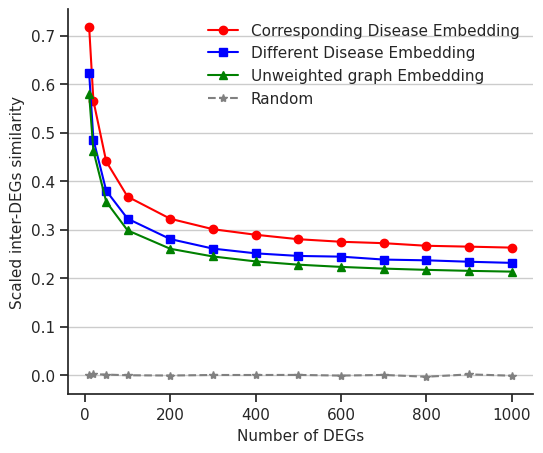

In [11]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# total_results = pickle.load(open("../data/fig4/inter_sim_z_scores_for_other_diseases.pkl", "rb"))
# total_results_other_diseases = pickle.load(open("../data/fig4/inter_sim_z_scores_other_diseases.pkl", "rb"))
# total_results_unweighted = pickle.load(open("../data/fig4/inter_sim_z_scores_unweighted.pkl", "rb"))
# total_results_random = pickle.load(open("../data/fig4/inter_sim_z_scores_random.pkl", "rb"))

fig, ax = plt.subplots(figsize=(6,5))

x = [10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
random_means = [np.array(total_results_random[i]).mean() for i in range(len(total_results_random))]
unweighted_means = [np.array(total_results_unweighted[i]).mean() for i in range(len(total_results_unweighted))]
weighted_means = [np.array(total_results[i]).mean() for i in range(len(total_results))]
other_disease_means = [np.array(total_results_other_diseases[i]).mean() for i in range(len(total_results_other_diseases))]
ax.plot(x, weighted_means, label="Corresponding Disease Embedding", marker="o", markersize=6, color="red")
ax.plot(x, other_disease_means, label="Different Disease Embedding", marker="s", markersize=6, color="blue")
ax.plot(x, unweighted_means, label="Unweighted graph Embedding", marker="^", markersize=6, color="green")
ax.plot(x, random_means, label="Random", marker="*", color="gray", markersize=6, linestyle="--")

ax.grid(True)
ax.set_xlabel("Number of DEGs", fontsize=11)
ax.set_ylabel("Scaled inter-DEGs similarity", fontsize=11)
ax.legend(fontsize=11, frameon=False)
ax.grid(False, axis="x")
plt.show()

fig.savefig("../data/fig4/fig4.inter_sim_z_scores.png", dpi=300, bbox_inches="tight")